# exercise 1-1

In [3]:
from mpi4py import MPI
from petsc4py.PETSc import ScalarType  # type: ignore

# +
import numpy as np

from dolfinx import fem, io, mesh, plot, default_scalar_type
from dolfinx.fem.petsc import LinearProblem

import ufl
from ufl import TrialFunction, TestFunction
from ufl import inner, dot, grad, dx, ds

import matplotlib.pyplot as plt
import time

In [11]:


def solve_poisson(N=16, degree=1):

    msh = mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=((0.0, 0.0), (1.0, 1.0)),
    n=(N, N),
    cell_type=mesh.CellType.triangle,
    )

    V = fem.functionspace(msh, ("Lagrange", degree))

    facets = mesh.locate_entities_boundary(
        msh,
        dim=(msh.topology.dim - 1),
        marker=lambda x: np.logical_or(np.logical_or(np.isclose(x[0], 0.0), np.isclose(x[0], 1.0)),np.logical_or(np.isclose(x[1], 0.0), np.isclose(x[1], 1.0))),
    )

    dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)

    bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)

    u = TrialFunction(V)
    v = TestFunction(V)

    x = ufl.SpatialCoordinate(msh)
    u_e = ufl.sin(ufl.pi * x[0])*ufl.sin(ufl.pi * x[1])
    f = 2*ufl.pi**2*u_e

    a = inner(grad(u), grad(v)) * dx
    L = inner(f, v) * dx
    problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    uh = problem.solve()
    return uh, u_e



def error_l2(eh):
    error = fem.form((eh)**2 * dx)
    E = np.sqrt(comm.allreduce(fem.assemble_scalar(error), MPI.SUM))
    return E

def error_h1(eh):
    error_H1 = fem.form(dot(grad(eh), grad(eh)) * dx + (eh)**2 * dx)
    E_H1 = np.sqrt(comm.allreduce(fem.assemble_scalar(error_H1), op=MPI.SUM))
    return E_H1

def u_ex(mod):
    return lambda x: mod.sin(mod.pi * x[0]) * mod.cos(mod.pi * x[1])

In [12]:
Ns = np.arange(2, 100, 10)
Es_l2 = np.zeros(len(Ns), dtype=default_scalar_type)
Es_h1 = np.zeros(len(Ns), dtype=default_scalar_type)

hs = np.zeros(len(Ns), dtype=np.float64)

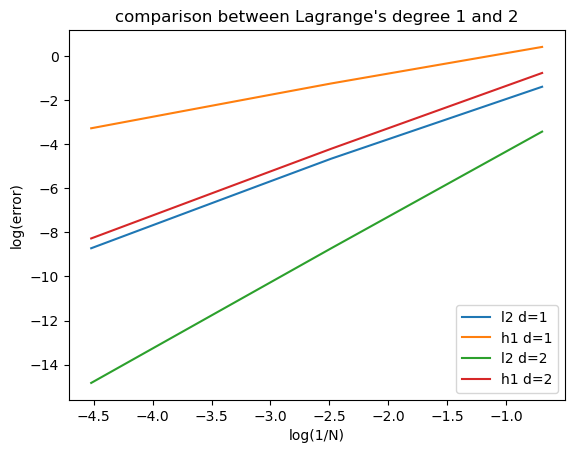

In [14]:
u_numpy = u_ex(np)

for i, N in enumerate(Ns):
    uh, u_e = solve_poisson(N, degree=1)
    comm = uh.function_space.mesh.comm
    # One can send in either u_numpy or u_ex
    # For L2 error estimations it is reccommended to send in u_numpy
    # as no JIT compilation is required
    Es_l2[i] = error_l2((uh - u_e))
    Es_h1[i] = error_h1((uh - u_e))
    hs[i] = 1. / Ns[i]


#plt.figure()
#plt.plot(np.log(hs), np.log(Es_l2))
#plt.plot(np.log(hs), np.log(Es_h1))
#plt.legend(["l2 norm", "h1 norm"])
#plt.title("degree=1")
#plt.show()

Ns = np.arange(2, 100, 10)
Es_l2_2 = np.zeros(len(Ns), dtype=default_scalar_type)
Es_h1_2 = np.zeros(len(Ns), dtype=default_scalar_type)
hs = np.zeros(len(Ns), dtype=np.float64)


for i, N in enumerate(Ns):
    uh, u_e = solve_poisson(N, degree=2)
    comm = uh.function_space.mesh.comm
    # One can send in either u_numpy or u_ex
    # For L2 error estimations it is reccommended to send in u_numpy
    # as no JIT compilation is required
    Es_l2_2[i] = error_l2((uh - u_e))
    Es_h1_2[i] = error_h1((uh - u_e))
    hs[i] = 1. / Ns[i]


#plt.figure()
#plt.plot(np.log(hs), np.log(Es_l2_2))
#plt.plot(np.log(hs), np.log(Es_h1_2))
#plt.legend(["l2 norm", "h1 norm"])
#plt.title("degree=2")
#plt.show()


plt.figure()
plt.plot(np.log(hs), np.log(Es_l2))
plt.plot(np.log(hs), np.log(Es_h1))
plt.plot(np.log(hs), np.log(Es_l2_2))
plt.plot(np.log(hs), np.log(Es_h1_2))
plt.xlabel("log(1/N)")
plt.ylabel("log(error)")
plt.legend(["l2 d=1", "h1 d=1", "l2 d=2", "h1 d=2"])
plt.title("comparison between Lagrange's degree 1 and 2")
plt.show()


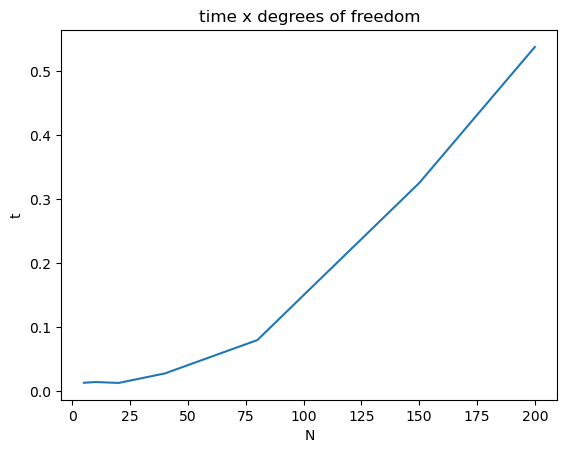

In [17]:


Ns = [5, 10, 20, 40,80,100,150,200]
n = np.zeros(len(Ns), dtype=np.float64)
t = np.zeros(len(Ns), dtype=default_scalar_type)
for i, N in enumerate(Ns):
    t0 = time.time()
    uh, u_e = solve_poisson(N, degree=1)
    t[i] = time.time() - t0
    n[i] = N



plt.figure()
plt.plot(n, t)
plt.title("time x degrees of freedom")
plt.xlabel("N")
plt.ylabel("t")
plt.show()  

# exercise 1-2

In [6]:
import gmsh
import sys
from dolfinx.io.gmshio import model_to_mesh
from mpi4py import MPI


gmsh.initialize()

gmsh.model.add("mesh")

# Define the geometry
lc = 0.1  # characteristic length for mesh size

# Add points for the rectangle
p1 = gmsh.model.geo.addPoint(0, 0, 0, lc)
p2 = gmsh.model.geo.addPoint(2, 0, 0, lc)
p3 = gmsh.model.geo.addPoint(2, 1, 0, lc)
p4 = gmsh.model.geo.addPoint(0, 1, 0, lc)

pc1=gmsh.model.geo.addPoint(0.5, 0.5-0.125, 0, lc/10)
pc2=gmsh.model.geo.addPoint(0.5, 0.5+0.125, 0, lc/10)
# Add points for the circle
pc = gmsh.model.geo.addPoint(0.5, 0.5, 0, lc/100)

# Add lines for the rectangle
l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p1)

# Create a circle
circle1 = gmsh.model.geo.addCircleArc(pc1, pc, pc2)
circle2 = gmsh.model.geo.addCircleArc(pc2, pc, pc1)

# Create curve loops and plane surfaces
outer_loop = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])
circle_loop = gmsh.model.geo.addCurveLoop([circle1,circle2])
plane_surface = gmsh.model.geo.addPlaneSurface([outer_loop, circle_loop])

# Synchronize necessary before meshing
gmsh.model.geo.synchronize()

# Define Physical Groups for boundaries
fluid = gmsh.model.addPhysicalGroup(2, [plane_surface], 0)  # Fluid
gmsh.model.setPhysicalName(1, fluid, "Fluid")

inflow = gmsh.model.addPhysicalGroup(1, [l4], 1)  # Inflow
gmsh.model.setPhysicalName(1, inflow, "Inflow")

outflow = gmsh.model.addPhysicalGroup(1, [l2], 2)  # Outflow
gmsh.model.setPhysicalName(1, outflow, "Outflow")

walls = gmsh.model.addPhysicalGroup(1, [l3, l1], 3)  # Walls
gmsh.model.setPhysicalName(1, walls, "Walls")

obstacle = gmsh.model.addPhysicalGroup(1, [circle1, circle2], 4)  # Obstacle
gmsh.model.setPhysicalName(1, obstacle, "Obstacle")

# Generate the mesh
gmsh.model.mesh.generate(2)

mesh, cell_tags, facet_tags = model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0,gdim=2)


gmsh.write("mesh_out.msh")

if '-nopopup' not in sys.argv:
    gmsh.fltk.run()




gmsh.finalize()


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 70%] Meshing curve 5 (Circle)
Info    : [ 90%] Meshing curve 6 (Circle)
Info    : Done meshing 1D (Wall 0.000513431s, CPU 0.000732s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0190222s, CPU 0.01963s)
Info    : 802 nodes 1609 elements
Info    : Writing 'mesh_out.msh'...
Info    : Done writing 'mesh_out.msh'
-------------------------------------------------------
Version       : 4.12.2
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20240121
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] LinuxJoystick MathEx[contrib] Med Mesh Metis[contrib] 

# exercise 1-3

## Read mesh

In [10]:
from dolfinx import io
from mpi4py import MPI

msh,cell_tags,facet_tags = io.gmshio.read_from_msh("/home/tomzhu0225/fenicsx_project/exercise/mesh_out.msh", MPI.COMM_WORLD , 0 , gdim=2)
print(facet_tags)
msh.topology.create_connectivity(msh.topology.dim, 0)
msh.topology.create_connectivity(msh.topology.dim, 1)
msh.topology.create_connectivity(msh.topology.dim, 2)


with io.XDMFFile( MPI.COMM_WORLD , f"/home/tomzhu0225/fenicsx_project/exercise/mesh_out.xdmf", "w") as xdmf :
    xdmf.write_mesh ( msh )
    xdmf.write_meshtags ( facet_tags , msh.geometry )
    xdmf.write_meshtags ( cell_tags , msh.geometry )

Info    : Reading '/home/tomzhu0225/fenicsx_project/exercise/mesh_out.msh'...
Info    : 14 entities
Info    : 801 nodes
Info    : 1602 elements
Info    : Done reading '/home/tomzhu0225/fenicsx_project/exercise/mesh_out.msh'


In [ ]:
# Note that it is important to first `from mpi4py import MPI` to
# ensure that MPI is correctly initialised.
from mpi4py import MPI
from dolfinx import io
from dolfinx import fem
import ufl
from basix.ufl import element , mixed_element
from ufl import TrialFunctions , TestFunctions
from ufl import inner, dot, grad, dx, ds
from dolfinx import fem, io, mesh, plot
from dolfinx.fem.petsc import LinearProblem
from petsc4py.PETSc import ScalarType
import numpy as np

file = io.XDMFFile(MPI.COMM_WORLD, "mesh_out.xdmf", "r")
msh = file.read_mesh()
tdim = msh.topology.dim
msh.topology.create_connectivity(tdim - 1 , tdim )
facet_tags = file.read_meshtags(msh , "Facet tags")  # try PhysicalNames



V_el = element ("Lagrange", msh.basix_cell() , 1)
Q_el = element ("Lagrange", msh.basix_cell() , 1)
VQ_el = mixed_element ([V_el , Q_el ])
W = fem.functionspace (msh , VQ_el )



(u , p) = TrialFunctions(W)
(v , q) = TestFunctions(W)


#ufl expression
x = ufl.SpatialCoordinate(msh)
u_e1 = ufl.sin(ufl.pi * x[0])*ufl.sin(ufl.pi * x[1])
f1 = 2*ufl.pi**2*u_e1

#u_e2 = 1*x[0]**2 * x[1]**2
#f2 = -2 * (x[1]**2 + x[0]**2)
f2 = 1

a = (inner(grad(u), grad(v)) + inner(grad(p), grad(q))) * dx
L = (inner(f1, v) + inner(f2, q) )* dx



fdim = msh.topology.dim - 1
u_D = ScalarType(0.)


# Applying Dirichlet boundary conditions u=0 in the Obstacle 
marker_id = 4 # Obstacle
dofs4_0 = fem.locate_dofs_topological(W.sub(0 ), fdim, facet_tags.find( marker_id ))
bc4_0 = fem.dirichletbc( u_D , dofs4_0 , W.sub(0))

dofs4_1 = fem.locate_dofs_topological(W.sub(1), fdim, facet_tags.find( marker_id ))
bc4_1 = fem.dirichletbc( u_D , dofs4_0 , W.sub(1))

# Applying Dirichlet boundary conditions u=0 in the Walls 
marker_id = 3 
dofs3_0 = fem.locate_dofs_topological(W.sub(0 ), fdim, facet_tags.find( marker_id ))
bc3_0 = fem.dirichletbc( u_D , dofs3_0 , W.sub(0))

dofs3_1 = fem.locate_dofs_topological(W.sub(1), fdim, facet_tags.find( marker_id ))
bc3_1 = fem.dirichletbc( u_D , dofs3_1 , W.sub(1))

# Applying Dirichlet boundary conditions u=0 in the Out Flow 
marker_id = 2 # Out Flow
dofs2_0 = fem.locate_dofs_topological(W.sub(0 ), fdim, facet_tags.find( marker_id ))
bc2_0 = fem.dirichletbc( u_D , dofs2_0 , W.sub(0))

dofs2_1 = fem.locate_dofs_topological(W.sub(1), fdim, facet_tags.find( marker_id ))
bc2_1 = fem.dirichletbc( u_D , dofs2_1 , W.sub(1))

# Applying Dirichlet boundary conditions u=1 in the In Flow 
marker_id = 1 # In Flow
dofs1_0 = fem.locate_dofs_topological(W.sub(0 ), fdim, facet_tags.find( marker_id ))
bc1_0 = fem.dirichletbc( ScalarType(1.) , dofs1_0 , W.sub(0))

dofs1_1 = fem.locate_dofs_topological(W.sub(1), fdim, facet_tags.find( marker_id ))
bc1_1 = fem.dirichletbc( ScalarType(1.) , dofs1_1 , W.sub(1))




problem = LinearProblem(a , L , bcs=[bc4_0, bc3_0, bc2_0, bc1_0, bc4_1, bc3_1, bc2_1, bc1_1])
wh = problem.solve()
(uh , ph ) = wh.split()


# +
with io.XDMFFile(msh.comm, "out_ex_1_2/result.xdmf", "w") as file:
    file.write_mesh(msh)
    file.write_function(uh)
    file.write_function(ph)
# -


try:
    import pyvista

    cells, types, x = plot.vtk_mesh(W.sub(1).collapse()[0])  # you can change this sub(1) with sub(1)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    grid.point_data["u"] = np.split(ph.x.array.real, 2)[1]  # you can change ph with uh, and also [1] with [0]
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=True)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        plotter.screenshot("uh_poisson.png")
    else:
        plotter.show()
except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")
# -


: 

# Exercise 2-1

### ver1

In [9]:
from mpi4py import MPI
from petsc4py import PETSc

import numpy as np
from dolfinx import cpp as _cpp

import ufl 
from ufl import Identity,FacetNormal,Measure,dot,Constant
from basix.ufl import element, mixed_element
from dolfinx import fem, la
from dolfinx.fem import (
    Constant,
    Function,
    dirichletbc,
    extract_function_spaces,
    form,
    functionspace,
    locate_dofs_topological,
)
from dolfinx.fem.petsc import assemble_matrix_block, assemble_vector_block
from dolfinx.io import XDMFFile
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from ufl import div, dx, grad, inner
from dolfinx import io
from petsc4py.PETSc import ScalarType
from dolfinx.fem.petsc import LinearProblem

# Create mesh
file = io.XDMFFile(MPI.COMM_WORLD, "./mesh_out.xdmf", "r")
msh = file.read_mesh()
tdim = msh.topology.dim
msh.topology.create_connectivity(tdim - 1 , tdim )
facet_tags = file.read_meshtags(msh , "Facet tags")  # try PhysicalNames


P2 = element("Lagrange", msh.basix_cell(), 2, shape=(msh.geometry.dim,))
P1 = element("Lagrange", msh.basix_cell(), 1)


# Create the Taylot-Hood function space
TH = mixed_element([P2, P1])
W = functionspace(msh, TH)

# No slip boundary condition
W0, _ = W.sub(0).collapse()



fdim = msh.topology.dim - 1
noslip = Function(W0)

# Applying Dirichlet boundary conditions u=(0, 0) in the Obstacle 

marker_id = 4 # Obstacle
dofs4 = fem.locate_dofs_topological((W.sub(0), W0), fdim, facet_tags.find( marker_id ))
bc4 = dirichletbc(noslip, dofs4, W.sub(0))

# Applying Dirichlet boundary conditions u=(0, 0) in the Walls 

marker_id = 3 # Walls
dofs3 = fem.locate_dofs_topological((W.sub(0), W0), fdim, facet_tags.find( marker_id ))
bc3 = dirichletbc(noslip, dofs3,  W.sub(0))

def lid_velocity_expression(x):
    return np.stack((-1/24*(x[1, :]- 6)*(x[1, :] + 6), np.zeros(x.shape[1])))
    # return np.stack((np.ones(x.shape[1]), np.zeros(x.shape[1])))

lid_velocity = Function(W0)
lid_velocity.interpolate(lid_velocity_expression)

marker_id = 1 # In Flow
dofs1 = fem.locate_dofs_topological((W.sub(0), W0), fdim, facet_tags.find( marker_id ))
bc1 = dirichletbc(lid_velocity, dofs1, W.sub(0))


bcs = [bc4, bc3, bc1]

(u, p) = ufl.TrialFunctions(W)
(v, q) = ufl.TestFunctions(W)
f = Function(W0)
a = form((inner(grad(u), grad(v)) - inner(p, div(v)) + inner(div(u), q)) * dx)
L = form(inner(f, v) * dx)


# Assemble LHS matrix and RHS vector
A = fem.petsc.assemble_matrix(a, bcs=bcs)
A.assemble()
b = fem.petsc.assemble_vector(L)

fem.petsc.apply_lifting(b, [a], bcs=[bcs])
b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)


# Set Dirichlet boundary condition values in the RHS
fem.petsc.set_bc(b, bcs)

# Create and configure solver
ksp = PETSc.KSP().create(msh.comm)
ksp.setOperators(A)
ksp.setType("preonly")

# Configure MUMPS to handle pressure nullspace
pc = ksp.getPC()
pc.setType("lu")
pc.setFactorSolverType("mumps")
pc.setFactorSetUpSolverType()
pc.getFactorMatrix().setMumpsIcntl(icntl=24, ival=1)
pc.getFactorMatrix().setMumpsIcntl(icntl=25, ival=0)


# Compute the solution
U = Function(W)
try:
    ksp.solve(b, U.vector)
except PETSc.Error as e:
    if e.ierr == 92:
        print("The required PETSc solver/preconditioner is not available. Exiting.")
        print(e)
        exit(0)
    else:
        raise e
    



# Split the mixed solution and collapse
u, p = U.sub(0).collapse(), U.sub(1).collapse()

# Compute norms
norm_u, norm_p = u.x.norm(), p.x.norm()
if MPI.COMM_WORLD.rank == 0:
    print(f"(D) Norm of velocity coefficient vector (monolithic, direct): {norm_u}")
    print(f"(D) Norm of pressure coefficient vector (monolithic, direct): {norm_p}")


with XDMFFile(MPI.COMM_WORLD, "worksheet2/out_stokes/velocity.xdmf", "w") as ufile_xdmf:
    u.x.scatter_forward()
    P1 = element("Lagrange", msh.basix_cell(), 1, shape=(msh.geometry.dim,))
    u1 = Function(functionspace(msh, P1))
    u1.interpolate(u)
    ufile_xdmf.write_mesh(msh)
    ufile_xdmf.write_function(u1)

with XDMFFile(MPI.COMM_WORLD, "worksheet2/out_stokes/pressure.xdmf", "w") as pfile_xdmf:
    p.x.scatter_forward()
    pfile_xdmf.write_mesh(msh)
    pfile_xdmf.write_function(p)


(D) Norm of velocity coefficient vector (monolithic, direct): 79.83550197690118
(D) Norm of pressure coefficient vector (monolithic, direct): 1863.242482318903


In [11]:
from dolfinx.fem import assemble_scalar
I = Identity(2)
n = -FacetNormal(msh)
# df = Constant((1.0, 0.0))
df = np.array([1, 0], dtype=ScalarType)
dp = np.array([0, 1], dtype=ScalarType)
sigma = -p * I + grad(u) + grad(u).T
obstacle_marker = 4
dObs = Measure("ds", domain =msh , subdomain_data = facet_tags ,
subdomain_id = obstacle_marker )
Fd_equation = fem.form(dot(sigma, n)*df*dObs)
# sigma*n*df*dObs
print(assemble_scalar(Fd_equation[0]))


46.65244206258274


### ver2

In [8]:
from mpi4py import MPI
from petsc4py import PETSc

import numpy as np
from dolfinx import cpp as _cpp

import ufl
from basix.ufl import element, mixed_element
from dolfinx import fem, la
from dolfinx.fem import (
    Constant,
    Function,
    dirichletbc,
    extract_function_spaces,
    form,
    functionspace,
    locate_dofs_topological,
    
)
from dolfinx.fem.petsc import assemble_matrix_block, assemble_vector_block
from dolfinx.io import XDMFFile
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from ufl import div, dx, grad, inner, Identity, ds, FacetNormal, dot, nabla_grad
from dolfinx import io
from petsc4py.PETSc import ScalarType
from dolfinx.fem.petsc import LinearProblem

# Create mesh
file = io.XDMFFile(MPI.COMM_WORLD, "./mesh_out.xdmf", "r")
msh = file.read_mesh()
tdim = msh.topology.dim
msh.topology.create_connectivity(tdim - 1 , tdim )
facet_tags = file.read_meshtags(msh , "Facet tags")  # try PhysicalNames


P2 = element("Lagrange", msh.basix_cell(), 2, shape=(msh.geometry.dim,))
P1 = element("Lagrange", msh.basix_cell(), 1)


# Create the Taylot-Hood function space
TH = mixed_element([P2, P1])
W = functionspace(msh, TH)


# No slip boundary condition
vector_space, _ = W.sub(0).collapse()
u_zero = Function(vector_space)
def bc_u_inflow(x):
	return np.stack((-1/24*(x[1,:]-6)*(x[1,:]+6), np.zeros(x.shape[1])))

vector_space, _ = W.sub(0).collapse()
u_R_inflow = Function(vector_space)
u_R_inflow.interpolate(bc_u_inflow)



fdim = msh.topology.dim - 1



dofs4 = fem.locate_dofs_topological((W.sub(0), vector_space), 1, facet_tags.find( 4 )) # Obstacle
bc4 = dirichletbc(u_zero, dofs4, W.sub(0))


dofs3 = fem.locate_dofs_topological((W.sub(0), vector_space), 1, facet_tags.find( 3 ))  # Walls
bc3 = dirichletbc(u_zero, dofs3,  W.sub(0))


dofs1 = fem.locate_dofs_topological((W.sub(0), vector_space), 1, facet_tags.find( 1 ))  # Inflow
bc1 = dirichletbc(u_R_inflow, dofs1, W.sub(0))


bcs = [bc1, bc3, bc4]  # If we change this order, the result changes LOL




(u, p) = ufl.TrialFunctions(W)
(v, q) = ufl.TestFunctions(W)
epsilon = 1e-6
a = (inner(nabla_grad(u), nabla_grad(v)) - p * div(v) + q * div(u) + epsilon*p*q)*dx 
L = inner(u_zero, v)*dx

# Create the function to contain the solution
w = Function(W)

# Solve the system
problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
w = problem.solve()

(u, p) = w.split()




# Compute objective
J = fem.form(.5 * inner(ufl.nabla_grad(u), ufl.nabla_grad(u))*dx)
J = fem.assemble_scalar(J)
print(f"J: {J}")



df =  fem.Constant(msh, ScalarType((1.,0.))) #Constant((1.0, 0.0))
dp =  fem.Constant(msh, ScalarType((0.,1.))) #Constant((0.0, 1.0))



sigma = -p * Identity(len(u)) + grad(u) + grad(u).T


print()

n = -FacetNormal(msh)
ds = ufl.Measure("ds", domain=msh, subdomain_data = facet_tags ,
subdomain_id = 4)


Fd_equation = fem.form(dot(dot(sigma, n), df) * ds)


Fl_equation = fem.form(dot(dot(sigma, n), dp) * ds)



print(f"Fd: {fem.assemble_scalar(Fd_equation)}")

print(f"Fl: {fem.assemble_scalar(Fl_equation)}")


"""
with io.XDMFFile(msh.comm, "worksheet2/out_stokes/res.xdmf", "w") as file:
                file.write_mesh(msh)
                file.write_meshtags(facet_tags, msh.geometry)
                u.name= " Velocity"
                file.write_function(u)
                p.name = "Pressure"
                file.write_function(p)
"""


with XDMFFile(MPI.COMM_WORLD, "worksheet2/out_stokes/velocity.xdmf", "w") as ufile_xdmf:
        u.x.scatter_forward()
        P1 = element("Lagrange", msh.basix_cell(), 1, shape=(msh.geometry.dim,))
        u1 = Function(functionspace(msh, P1))
        u1.interpolate(u)
        ufile_xdmf.write_mesh(msh)
        ufile_xdmf.write_function(u1)

with XDMFFile(MPI.COMM_WORLD, "worksheet2/out_stokes/pressure.xdmf", "w") as pfile_xdmf:
    p.x.scatter_forward()
    pfile_xdmf.write_mesh(msh)
    pfile_xdmf.write_function(p)

J: 76.06736855283336

Fd: 45.18800212175511
Fl: 0.10850978267653225


# Exercise 3

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def rotate(x, y, theta):
    """Rotate points around the origin by theta degrees."""
    theta_rad = np.radians(theta)
    xr = x * np.cos(theta_rad) - y * np.sin(theta_rad)
    yr = x * np.sin(theta_rad) + y * np.cos(theta_rad)
    return xr, yr

def naca4(number, chord=0.1, n=100, angle_of_attack=0):
    m = int(number[0]) / 100.0
    p = int(number[1]) / 10.0
    t = int(number[2:]) / 100.0
    
    x = np.linspace(0, 1, n)
    x = (0.5 * (1 - np.cos(np.pi * x))) * chord
    
    yt = 5 * t * chord * (0.2969 * np.sqrt(x/chord) - 0.1260 * (x/chord) - 0.3516 * (x/chord)**2 + 0.2843 * (x/chord)**3 - 0.1015 * (x/chord)**4)
    
    yc = np.where(x < p * chord, m * (x / np.power(p, 2)) * (2 * p - (x / chord)), m * ((chord - x) / np.power(1-p, 2)) * (1 + (x / chord) - 2 * p))
    dyc_dx = np.where(x < p * chord, 2*m / np.power(p, 2) * (p - x / chord), 2*m / np.power(1-p, 2) * (p - x / chord))
    theta = np.arctan(dyc_dx)
    
    xu = x - yt * np.sin(theta)
    yu = yc + yt * np.cos(theta)
    xl = x + yt * np.sin(theta)
    yl = yc - yt * np.cos(theta)

    # Rotate coordinates for angle of attack
    xu, yu = rotate(xu, yu, angle_of_attack)
    xl, yl = rotate(xl, yl, angle_of_attack)
    
    # plt.figure(figsize=(10, 5))
    # plt.plot(xu, yu, 'b')
    # plt.plot(xl, yl, 'r')
    # plt.title(f'NACA {number} at {angle_of_attack}° AoA')
    # plt.xlabel('X')
    # plt.ylabel('Y')
    # plt.axis('equal')
    # plt.grid(True)
    # plt.show()
    return xu,yu,xl,yl
# Example: Generate NACA 2412 airfoil with a 5-degree angle of attack
def naca4_full(number, chord=0.1, n=50, angle_of_attack=0):
    m = int(number[0]) / 100.0
    p = int(number[1]) / 10.0
    t = int(number[2:]) / 100.0
    
    x = np.linspace(0, 1, n)
    x = (0.5 * (1 - np.cos(np.pi * x))) * chord
    
    yt = 5 * t * chord * (0.2969 * np.sqrt(x/chord) - 0.1260 * (x/chord) - 0.3516 * (x/chord)**2 + 0.2843 * (x/chord)**3 - 0.1015 * (x/chord)**4)
    
    yc = np.where(x < p * chord, m * (x / np.power(p, 2)) * (2 * p - (x / chord)), m * ((chord - x) / np.power(1-p, 2)) * (1 + (x / chord) - 2 * p))
    dyc_dx = np.where(x < p * chord, 2*m / np.power(p, 2) * (p - x / chord), 2*m / np.power(1-p, 2) * (p - x / chord))
    theta = np.arctan(dyc_dx)
    
    xu = x - yt * np.sin(theta)
    yu = yc + yt * np.cos(theta)
    xl = x + yt * np.sin(theta)
    yl = yc - yt * np.cos(theta)

    # Rotate coordinates for angle of attack
    xu, yu = rotate(xu, yu, angle_of_attack)
    xl, yl = rotate(xl, yl, angle_of_attack)
    
    # Combine upper and lower surfaces into one loop without duplicating the trailing edge
    x_full = np.concatenate([xu[:-1], xl[::-1]])[:-1]
    y_full = np.concatenate([yu[:-1], yl[::-1]])[:-1]
    
    return x_full, y_full

naca4_full("6412", angle_of_attack=20)

(array([ 0.        , -0.00025024, -0.00031697, -0.00019824,  0.00010765,
         0.00060206,  0.00128593,  0.00215969,  0.00322311,  0.00447521,
         0.00591416,  0.0075371 ,  0.00934012,  0.01131814,  0.01346487,
         0.01577276,  0.01823306,  0.02083581,  0.02356991,  0.02642322,
         0.02938266,  0.03243435,  0.03551541,  0.03862207,  0.041765  ,
         0.04492986,  0.04810226,  0.05126777,  0.05441205,  0.0575209 ,
         0.06058032,  0.06357656,  0.06649622,  0.06932623,  0.07205399,
         0.07466734,  0.07715465,  0.07950487,  0.08170755,  0.08375292,
         0.0856319 ,  0.08733615,  0.08885812,  0.09019106,  0.09132906,
         0.0922671 ,  0.09300102,  0.09352758,  0.09384445,  0.0939883 ,
         0.09388697,  0.09358349,  0.09307946,  0.09237748,  0.09148118,
         0.09039519,  0.08912506,  0.08767725,  0.08605906,  0.08427858,
         0.08234462,  0.08026664,  0.07805471,  0.07571936,  0.07327158,
         0.07072269,  0.06808429,  0.06536814,  0.0

In [15]:
import gmsh
import sys
from dolfinx.io.gmshio import model_to_mesh
from mpi4py import MPI


gmsh.initialize()

gmsh.model.add("mesh")

# Define the geometry
lc = 0.1  # characteristic length for mesh size

# Add points for the rectangle
p1 = gmsh.model.geo.addPoint(0, 0, 0, lc)
p2 = gmsh.model.geo.addPoint(2, 0, 0, lc)
p3 = gmsh.model.geo.addPoint(2, 1, 0, lc)
p4 = gmsh.model.geo.addPoint(0, 1, 0, lc)



# Add lines for the rectangle
l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p1)

center_x=0.7
center_y=0.4
x,y=naca4_full("6412",chord=0.7, angle_of_attack=10)
x,y=x+center_x,y+center_y

airfoil_points = []
for xi, yi in zip(x, y):
    pid = gmsh.model.geo.addPoint(xi, yi, 0, lc/10)
    airfoil_points.append(pid)

# Add lines for the airfoil
airfoil_lines = []
for i in range(len(airfoil_points) - 1):
    lid = gmsh.model.geo.addLine(airfoil_points[i], airfoil_points[i + 1])
    airfoil_lines.append(lid)
# Close the airfoil loop by connecting the last point back to the first
airfoil_lines.append(gmsh.model.geo.addLine(airfoil_points[-1], airfoil_points[0]))





# Create curve loops and plane surfaces
outer_loop = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])
wing_loop = gmsh.model.geo.addCurveLoop(airfoil_lines)
plane_surface = gmsh.model.geo.addPlaneSurface([outer_loop, wing_loop])


# Synchronize necessary before meshing
gmsh.model.geo.synchronize()

# Define Physical Groups for boundaries
fluid = gmsh.model.addPhysicalGroup(2, [plane_surface], 0)  # Fluid
gmsh.model.setPhysicalName(1, fluid, "Fluid")

inflow = gmsh.model.addPhysicalGroup(1, [l4], 1)  # Inflow
gmsh.model.setPhysicalName(1, inflow, "Inflow")

outflow = gmsh.model.addPhysicalGroup(1, [l2], 2)  # Outflow
gmsh.model.setPhysicalName(1, outflow, "Outflow")

walls = gmsh.model.addPhysicalGroup(1, [l3, l1], 3)  # Walls
gmsh.model.setPhysicalName(1, walls, "Walls")

obstacle = gmsh.model.addPhysicalGroup(1, airfoil_lines, 4)
gmsh.model.setPhysicalName(1, obstacle, "Obstacle")

# Generate the mesh
gmsh.model.mesh.generate(2)

mesh, cell_tags, facet_tags = model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0,gdim=2)


gmsh.write("mesh_wing.msh")

if '-nopopup' not in sys.argv:
    gmsh.fltk.run()




gmsh.finalize()


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 10%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 20%] Meshing curve 14 (Line)
Info    : [ 20%] Meshing curve 15 (Line)
Info    : [ 20%] Meshing curve 16 (Line)
Info    : [ 20%] Meshing curve 17 (Line)
Info    : [ 20%] Meshing curve 18 (Line)
Info    : [ 20%] Meshing curve 19 (Line)
Info    : [ 20%] Meshing curve 20 (Line)
Info    : [ 20%] Meshing curve 21 (Line)
Info    : [ 30%] Meshing curve 22 (Line)
Info    : [ 30%] Meshing curve 23 (Line)
Info    : [ 30%] Meshing curve 24 (Line)
I

In [12]:
from dolfinx import io
from mpi4py import MPI

msh,cell_tags,facet_tags = io.gmshio.read_from_msh("/home/tomzhu0225/fenicsx_project/exercise/mesh_wing.msh", MPI.COMM_WORLD , 0 , gdim=2)
print(facet_tags)
msh.topology.create_connectivity(msh.topology.dim, 0)
msh.topology.create_connectivity(msh.topology.dim, 1)
msh.topology.create_connectivity(msh.topology.dim, 2)


with io.XDMFFile( MPI.COMM_WORLD , f"/home/tomzhu0225/fenicsx_project/exercise/mesh_wing.xdmf", "w") as xdmf :
    xdmf.write_mesh ( msh )
    xdmf.write_meshtags ( facet_tags , msh.geometry )
    xdmf.write_meshtags ( cell_tags , msh.geometry )

Info    : Reading '/home/tomzhu0225/fenicsx_project/exercise/mesh_wing.msh'...
Info    : 205 entities
Info    : 1757 nodes
Info    : 3514 elements
Info    : Done reading '/home/tomzhu0225/fenicsx_project/exercise/mesh_wing.msh'


In [14]:
from mpi4py import MPI
from petsc4py import PETSc

import numpy as np
from dolfinx import cpp as _cpp

import ufl
from basix.ufl import element, mixed_element
from dolfinx import fem, la
from dolfinx.fem import (
    Constant,
    Function,
    dirichletbc,
    extract_function_spaces,
    form,
    functionspace,
    locate_dofs_topological,
    
)
from dolfinx.fem.petsc import assemble_matrix_block, assemble_vector_block
from dolfinx.io import XDMFFile
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from ufl import div, dx, grad, inner, Identity, ds, FacetNormal, dot, nabla_grad
from dolfinx import io
from petsc4py.PETSc import ScalarType
from dolfinx.fem.petsc import LinearProblem

# Create mesh
file = io.XDMFFile(MPI.COMM_WORLD, "./mesh_wing.xdmf", "r")
msh = file.read_mesh()
tdim = msh.topology.dim
msh.topology.create_connectivity(tdim - 1 , tdim )
facet_tags = file.read_meshtags(msh , "Facet tags")  # try PhysicalNames


P2 = element("Lagrange", msh.basix_cell(), 2, shape=(msh.geometry.dim,))
P1 = element("Lagrange", msh.basix_cell(), 1)


# Create the Taylot-Hood function space
TH = mixed_element([P2, P1])
W = functionspace(msh, TH)


# No slip boundary condition
vector_space, _ = W.sub(0).collapse()
u_zero = Function(vector_space)
def bc_u_inflow(x):
	return np.stack((-1/24*(x[1,:]-6)*(x[1,:]+6), np.zeros(x.shape[1])))

vector_space, _ = W.sub(0).collapse()
u_R_inflow = Function(vector_space)
u_R_inflow.interpolate(bc_u_inflow)



fdim = msh.topology.dim - 1



dofs4 = fem.locate_dofs_topological((W.sub(0), vector_space), 1, facet_tags.find( 4 )) # Obstacle
bc4 = dirichletbc(u_zero, dofs4, W.sub(0))


dofs3 = fem.locate_dofs_topological((W.sub(0), vector_space), 1, facet_tags.find( 3 ))  # Walls
bc3 = dirichletbc(u_zero, dofs3,  W.sub(0))


dofs1 = fem.locate_dofs_topological((W.sub(0), vector_space), 1, facet_tags.find( 1 ))  # Inflow
bc1 = dirichletbc(u_R_inflow, dofs1, W.sub(0))


bcs = [bc3,bc1, bc4]  # If we change this order, the result changes LOL




(u, p) = ufl.TrialFunctions(W)
(v, q) = ufl.TestFunctions(W)
epsilon = 1e-6
a = (inner(nabla_grad(u), nabla_grad(v)) - p * div(v) + q * div(u) + epsilon*p*q)*dx 
L = inner(u_zero, v)*dx

# Create the function to contain the solution
w = Function(W)

# Solve the system
problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
w = problem.solve()

(u, p) = w.split()




# Compute objective
J = fem.form(.5 * inner(ufl.nabla_grad(u), ufl.nabla_grad(u))*dx)
J = fem.assemble_scalar(J)
print(f"J: {J}")



df =  fem.Constant(msh, ScalarType((1.,0.))) #Constant((1.0, 0.0))
dp =  fem.Constant(msh, ScalarType((0.,1.))) #Constant((0.0, 1.0))



sigma = -p * Identity(len(u)) + grad(u) + grad(u).T


print()

n = -FacetNormal(msh)
ds = ufl.Measure("ds", domain=msh, subdomain_data = facet_tags ,
subdomain_id = 4)


Fd_equation = fem.form(dot(dot(sigma, n), df) * ds)


Fl_equation = fem.form(dot(dot(sigma, n), dp) * ds)



print(f"Fd: {fem.assemble_scalar(Fd_equation)}")

print(f"Fl: {fem.assemble_scalar(Fl_equation)}")


"""
with io.XDMFFile(msh.comm, "worksheet2/out_stokes/res.xdmf", "w") as file:
                file.write_mesh(msh)
                file.write_meshtags(facet_tags, msh.geometry)
                u.name= " Velocity"
                file.write_function(u)
                p.name = "Pressure"
                file.write_function(p)
"""


with XDMFFile(MPI.COMM_WORLD, "worksheet3/out_stokes/velocity_wing.xdmf", "w") as ufile_xdmf:
        u.x.scatter_forward()
        P1 = element("Lagrange", msh.basix_cell(), 1, shape=(msh.geometry.dim,))
        u1 = Function(functionspace(msh, P1))
        u1.interpolate(u)
        ufile_xdmf.write_mesh(msh)
        ufile_xdmf.write_function(u1)

with XDMFFile(MPI.COMM_WORLD, "worksheet3/out_stokes/pressure_wing.xdmf", "w") as pfile_xdmf:
    p.x.scatter_forward()
    pfile_xdmf.write_mesh(msh)
    pfile_xdmf.write_function(p)

J: 86.59754719971167

Fd: 45.63105430801093
Fl: -14.614988533620084
